## 1. Loading and visualizing audio

In [1]:
# Enable plots in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Seaborn is better for plot
import seaborn
seaborn.set(style='ticks')

# Import audio playback widget
from IPython.display import Audio

# There are generally useful to have around
import numpy as np
import scipy


import mir_eval

In [3]:
import librosa
import librosa.display

In [4]:
y, sr = librosa.load('wav.wav', sr=41000)

print('Sampling rate %d' % sr)
print('Samples : %d' %(y.size))
print('Duration of audio : %d s'%(y.size/sr))

/home/abdus/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Sampling rate 41000
Samples : 125667
Duration of audio : 3 s


## We can playback audio with the Ipython audio widget

In [5]:
Audio(data = y, rate = sr)

## Display module can plot waveforms

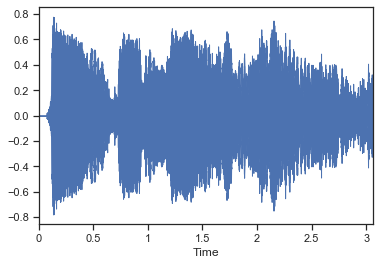

In [6]:
librosa.display.waveplot(y = y, sr = sr)

## 2. Spectrograms
### Spectrograms are stored as 2D arrays. y axis is frequency and x axis is time.
sr = sampling rate  <br>
frame = short audio clip(spectrogram column) <br>
n_fft = sample per frame <br>
hop_length = # samples between frames <br>
stft = short time fourier transform

## Short time fourier transform

In [8]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))

## Spectrogram

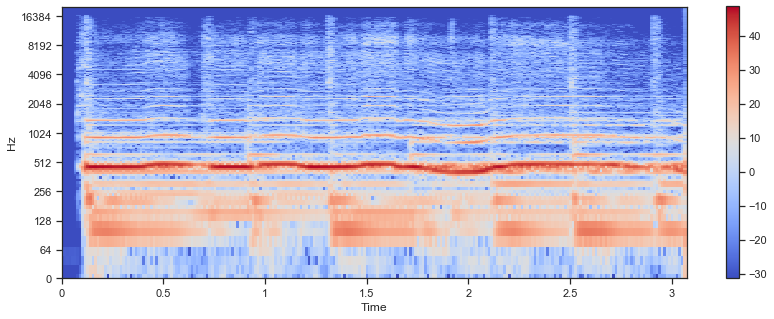

In [9]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## What I want direct log frequeny analysis?
Instead of STFT, we can use Constant Q-transform(CQT)

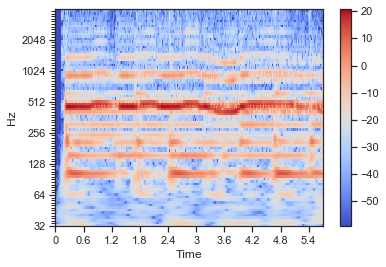

In [10]:
c = librosa.cqt(y, sr)
librosa.display.specshow(librosa.amplitude_to_db(abs(c)),x_axis='time', y_axis='cqt_hz')
plt.colorbar()

## 3. Spectral features
1. use to analyze harmony or timbre
2. Product of a spectrogram
3. Feature bank <br>

### Pitch vs Pitch class
-----------------------------
CQT measures the energy in each pitch <br>
Chroma measures the enery in each pitch class

/home/abdus/anaconda3/lib/python3.7/site-packages/librosa/display.py:725: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


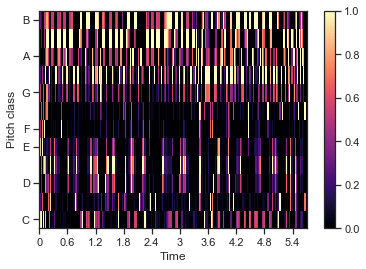

In [11]:
chroma = librosa.feature.chroma_cqt(C = c, sr = sr)
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma')
plt.colorbar()

## Other spectral features include Mel spectra, MFCC and Tonnetz

In [14]:
m = librosa.feature.melspectrogram(y = y, sr = sr)
mfcc = librosa.feature.mfcc(y = y, sr = sr)
tonnetz = librosa.feature.tonnetz(y = y, sr = sr)

## 4. Audio effects

In [15]:
# 1. harmonic percussive separtion
y_harmonic, y_percussive = librosa.effects.hpss(y)

In [17]:
Audio(data = y, rate =sr)

In [18]:
Audio(data = y_harmonic, rate =sr)

In [19]:
Audio(data = y_percussive, rate =sr)

In [26]:
## Now compare full vs harmonic CQT
c_harmonic = librosa.cqt(y = y_harmonic, sr = sr)
c_perc = librosa.cqt(y = y_percussive, sr = sr)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0854204090>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0854204090>)

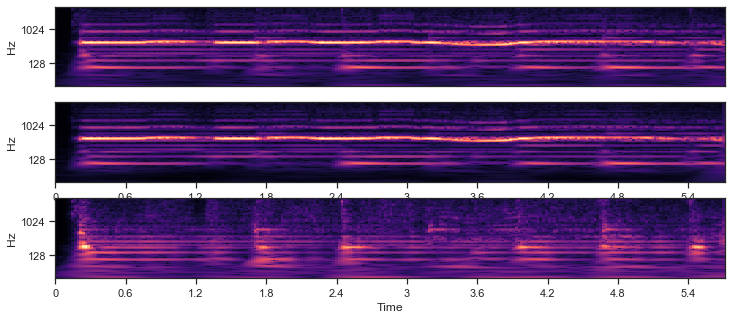

In [31]:
plt.figure(figsize=(12, 5))
plt.subplot(3, 1, 1), librosa.display.specshow(c**(1./3), y_axis='cqt_hz')
plt.subplot(3, 1, 2), librosa.display.specshow(c_harmonic**(1./3), y_axis='cqt_hz', x_axis='time')
plt.subplot(3, 1, 3), librosa.display.specshow(c_perc**(1./3), y_axis='cqt_hz', x_axis='time')

## 5. Onsets and beats
onset strength envelope

In [33]:
onset_envelope = librosa.onset.onset_strength(y, sr)

Onset events can be detected

In [34]:
onsets = librosa.onset.onset_detect(onset_envelope=onset_envelope)

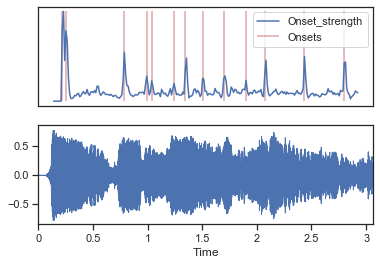

In [49]:
plt.subplot(2, 1, 1)
plt.plot(onset_envelope, label = 'Onset_strength')
plt.vlines(onsets, 0, onset_envelope.max(), color='r', alpha=0.5, label = 'Onsets')
plt.xticks([]), plt.yticks([])
plt.legend(frameon=True)
plt.axis('tight')

plt.subplot(2, 1, 2)
librosa.display.waveplot(y, sr)

## onset strength is used to track beats and estimate tempo

In [50]:
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_envelope)
print(tempo)

112.34714673913044


(-12.25, 257.25, -0.05, 1.05)

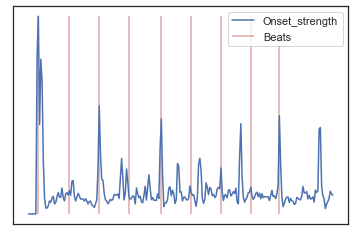

In [51]:
plt.plot(onset_envelope, label = 'Onset_strength')
plt.vlines(beats, 0, onset_envelope.max(), color='r', alpha=0.5, label = 'Beats')
plt.xticks([]), plt.yticks([])
plt.legend(frameon=True)
plt.axis('tight')

## Beat event are in frame indices
We can convert to time and sonify with mir_eval

In [55]:
beat_times = librosa.frames_to_time(beats)
y_click = mir_eval.sonify.clicks(beat_times, sr, length=len(y))
Audio(data = y + y_click, rate = sr)

## 6. Temporal structure
How do we deal with time, repition and structure?

/home/abdus/anaconda3/lib/python3.7/site-packages/librosa/display.py:725: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


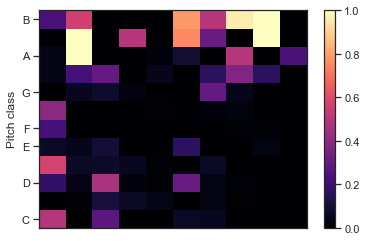

In [58]:
# Beat synchronous feature aggregation
c_sync = librosa.util.sync(chroma, beats, aggregate=np.median)

librosa.display.specshow(c_sync, y_axis='chroma')
plt.colorbar()

## History embedding can add context

/home/abdus/anaconda3/lib/python3.7/site-packages/librosa/display.py:725: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


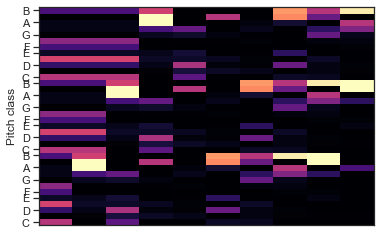

In [60]:
chroma_stack = librosa.feature.stack_memory(c_sync, n_steps=3, mode='edge')

librosa.display.specshow(chroma_stack, y_axis='chroma')

#### Recurrence plts show neatrest neightbor linkage for each frame.
Chroma recurrence can encode harmonic repetitions


In [ ]:
R = librosa.segment.recurrence_matrix(chroma_stack, sym=True)

In [ ]:
librosa.display.specshow(R, aspect='equal')